## Extract compositional information from a map of a porphyrtic lava

In [1]:
# import the chemMap package
import chemMap

# import common python packages for data processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# turn off certain warnings and use the matplotlib backend: Qt5Agg to get interactive plots
pd.options.mode.chained_assignment = default='warn'
np.seterr(divide='ignore', invalid = 'ignore')
#%matplotlib

# set basic plot parameters (or preferences)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})

First we need to define the elements that we are interested in and load them into a Python Dictionary. The loadcnt function will search for datafiles titled 'E K series.csv' in the specified folder (where E represents any of the specified elements).

By specifying 'filter = True' we apply a 3-by-3 median filter to the raw data. This helps to remove artifacts whilst maintaining boundaries.

Finally, the resolution, in μm, is also specified.

In [2]:
Elements = ['Fe','Mg','Ca','Ti','Cr','Al','Na','Si','K']
Flo09W = chemMap.loadcnt('Galapagos/',Elements, filter=True)

Resolution=11

Now that the raw data has been imported, we can carry out k-means cluster analysis to determine whether we can identify different mineral phases in our sample, and also isolate background regions, or areas of no data (so that they can be avoided in further analysis).

In this first example we split the pixels into 5 different clusters and plot a map of the results (we can also specify a narrower range of elements if we wish for only a select group to be used for the cluster analysis). By specifying 'ShowComp = True', we can also ask the code to print the average count rates for each cluster. However, another way to do this is to specify 'Name = True', which promts the code to print the name of the different clusters and allows me to enter a three letter identification code for each one.

Using the outputted count rates and prior knowledge of the sample (i.e., that it is a basaltic lava flow) it is relatively easy to identify the different mineral phases. For example, Cluster 0 contains abundant Si, Al, and Ca, but little to no Mg, indicating that this is likely plagioclase (or 'Plg' here). Cluster 1 has very low count rates for all elements and so likely represents the region surrounding the map and/or any cracks/holes within the sample (here termed 'nan' areas). Cluster 2 has low Si, but high Al, indicating that this is likely an Alumina Spinel. Cluster 4 contains high Mg and moderate Si values characteristic of olivine ('Oli'), and Cluster 4 contains high Ca, Si, Mg, Fe and Al so likely represents clinopyroxene ('Cpx').

In [3]:
Elements = ['Fe','Mg','Ca','Ti','Cr','Al','Na','Si','K']
Flo09W = chemMap.Cluster(Flo09W, Elements, 5, Name = ['Plg','nan','Spl','Oli','Cpx'])

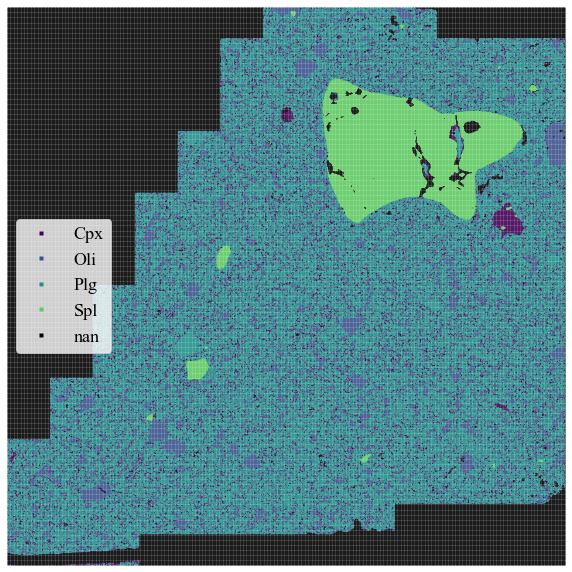

In [4]:
a = chemMap.PlotCluster(Flo09W, 5, Name = list(np.unique(Flo09W['Cluster'])))

Once we have identified the different clusters, and named them, we can start to assess the chemical properties/distributions of the various minerals. One interesting possibility is using the size distribution of a particular mineral phase to isolate mineral sub-groups. Here we choose to focus on olivine, as the maps show that the individual olivine crystals are isolated from each other (i.e., surrounded by clinopyroxene or plagioclase). This is important as the code searchs for the number of neighbouring, or touching pixels with the same cluster classification and, as a result, an interconnected framework of small groundmass crystals would be characterised as one very large crystal!

The Size function used below creates a numpy array of the same size of those for each element. Nan values are applied to any pixel that is not classified as the chosen cluster and each pixel of that cluster is assigned a value equal to the sum of pixels in that area that are classified as the chose cluster and are connected.

In [5]:
Flo09W = chemMap.Size(Flo09W, Cluster = 'Oli')

For minerals like olivine, however, plotting raw count values isn't particulary useful. Luckily, work by Matthew Locke, a former PhD student at Cardiff University, on a whole host of mineral and metal standards determined the correction factors that need to be applied to convert raw count ratios into ratios that are commonly used to describe mineral compositions (e.g., Anorthite content, Ca/(Ca+Na); Mg#, Mg/(Mg+Fe)).

Using the correction factors provided in the Quack software (see github.com/ianthomas23/QACD-quack) we can convert the raw count values into these ratios. 

In [6]:
Quant_MgNo = chemMap.detRatio(Flo09W, Elements, corr = 'olivine', ratio = 'Mg#')

Quant_An = chemMap.detRatio(Flo09W, Elements, corr = 'feldspar', ratio = 'An')

# assign these individual numpy arrays to the main Python dictionary
Flo09W['Olivine_Mg#'] = Quant_MgNo
Flo09W['Plagioclase_An'] = Quant_An

Now that these ratios have been determined, we can start to assess the compositional distributions of the different mineral phases. First, lets plot up a compositional map of the Forsterite content of olivine and the Anorthite content of plagioclase.

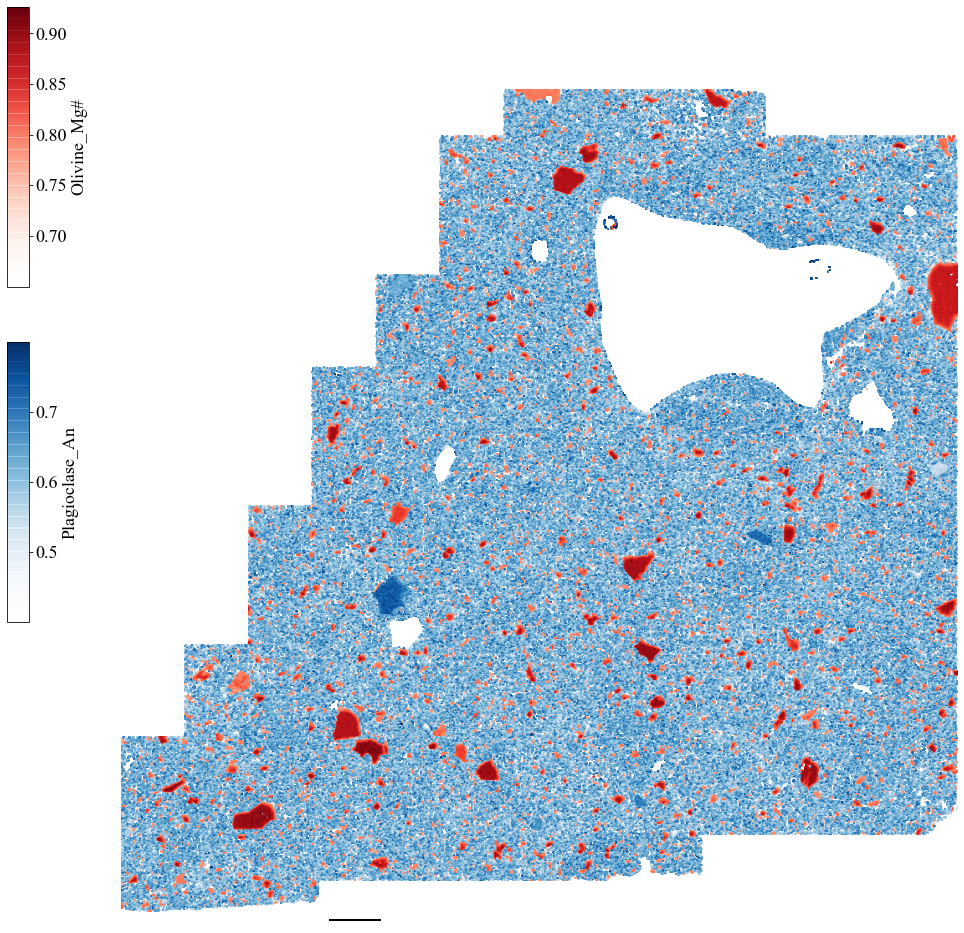

In [7]:
f, b = chemMap.ElementMap(Flo09W, ['Olivine_Mg#','Plagioclase_An'], ColMap = ['Reds','Blues'], 
                        Resolution = Resolution, Bounds = [[0.65, 0.95],[0.4,0.8]], Cluster = ['Oli','Plg'])

We can also extract the quantitative mineral compositions. For example, here we plot the composition of all olivines with typical areas less than ~50,000 μm^2, and those with areas greater than this specified area.

Text(0, 0.5, 'Density')

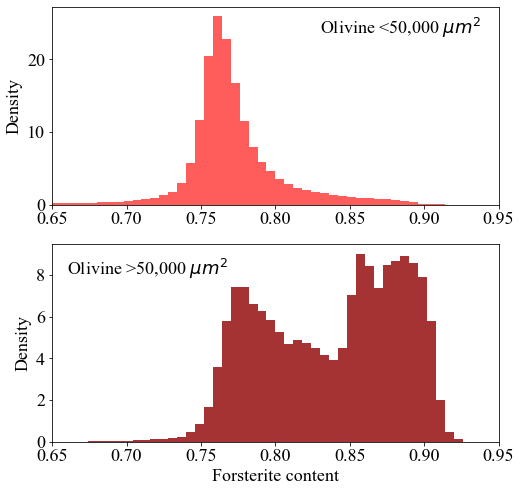

In [8]:
Area = (50000)/(Resolution**2)

f, a = plt.subplots(2,1, figsize=(8,8))
a[0].hist(Flo09W['Olivine_Mg#'][(Flo09W['Cluster']=='Oli') & (Flo09W['Size']<Area)], 
          bins  = np.linspace(0.65,0.95,51), density = True, facecolor = [1,0.2,0.2], alpha = 0.8)
a[0].set_xlim([0.65, 0.95])
a[0].set_ylabel('Density')
a[0].text(0.83, 23.5, 'Olivine <50,000 $\mu m ^{2}$')

a[1].hist(Flo09W['Olivine_Mg#'][(Flo09W['Cluster']=='Oli') & (Flo09W['Size']>Area)], 
          bins  = np.linspace(0.65,0.95,51), density = True, facecolor = [0.56,0,0], alpha = 0.8)
a[1].set_xlim([0.65, 0.95])
a[1].set_xlabel('Forsterite content')
a[1].text(0.66, 8.0,'Olivine >50,000 $\mu m ^{2}$')
a[1].set_ylabel('Density')